<a href="https://colab.research.google.com/github/Nadiam75/DeepLearning_HW_3/blob/main/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes()
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
pad_token = '<PAD>'

In [7]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [8]:

columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [9]:
testData = testData.loc[testData["polarity"] != 2]


In [10]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [11]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [12]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [13]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [17]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2022-01-01 17:43:29--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2022-01-01 17:43:29--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-01-01 17:43:29--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [18]:
!unzip glove.42B.300d.zip
# !rm glove.42B.300d.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_embeddings(filename):
    labels = []
    rows = []
    result = {}
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
            result [items[0]] = values
    # arr = np.vstack(rows)
    return result
    # return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')


1917494it [03:57, 8067.94it/s]


In [20]:
len(embeddings)

1917494

In [ ]:
# import pickle
# file = open('content/drive/MyDrive/my_embeddings.pickle','wb')
# pickle.dump(embeddings, file)
# file.close()


In [ ]:
!ls

In [24]:
with open('saved_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [25]:
import pickle
file = open('embeddings.pickle','wb')
pickle.dump(embeddings, file)
file.close()


In [26]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# def load_embeddings(filename):
#     labels = []
#     rows = []
#     with open(filename, encoding='utf-8') as infile:
#         for i, line in tqdm(enumerate(infile)):
#             items = line.rstrip().split(' ')
#             if len(items) == 2:
#                 # This is a header row giving the shape of the matrix
#                 continue
#             labels.append(items[0])
#             values = np.array([float(x) for x in items[1:]], 'f')
#             rows.append(values)
    
#     arr = np.vstack(rows)
#     return pd.DataFrame(arr, index=labels, dtype='f')

# embeddings = load_embeddings('glove.42B.300d.txt')
# embeddings.shape

In [27]:
# embeddings.head()

In [28]:
(embeddings.get('the')).shape

(300,)

In [29]:
testData.head()

,polarity,id,date,query,user,text
0,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,1,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...


In [30]:
trainData.head()

,polarity,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [31]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id']
del testData['date']
del testData['query']
del testData['user']
del trainData ['id']
del trainData['date']
del trainData['query']
del trainData['user']

In [32]:
testData.shape

(358, 2)

In [33]:
trainData.shape

(1599999, 2)

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

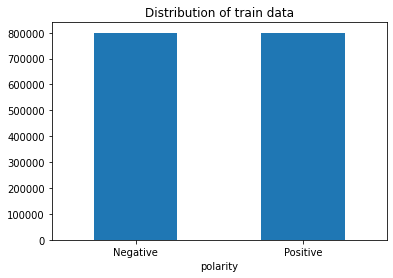

In [34]:
ax = trainData.groupby('polarity').count().plot(kind='bar', title='Distribution of train data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

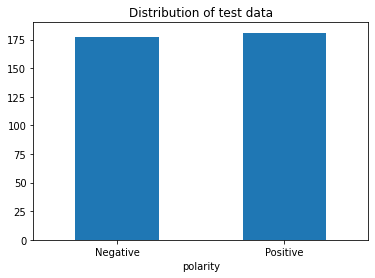

In [35]:
ax = testData.groupby('polarity').count().plot(kind='bar', title='Distribution of test data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [36]:
text, sentiment = list(trainData['text']), list(trainData['polarity'])

In [37]:
test_text, test_sentiment = list(testData['text']), list(testData['polarity'])

In [38]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 153 seconds


In [42]:
import time
t = time.time()
processed_test_text = preprocess(test_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0 seconds


In [43]:
len(processedtext)

1599999

Word-Cloud for Negative tweets.

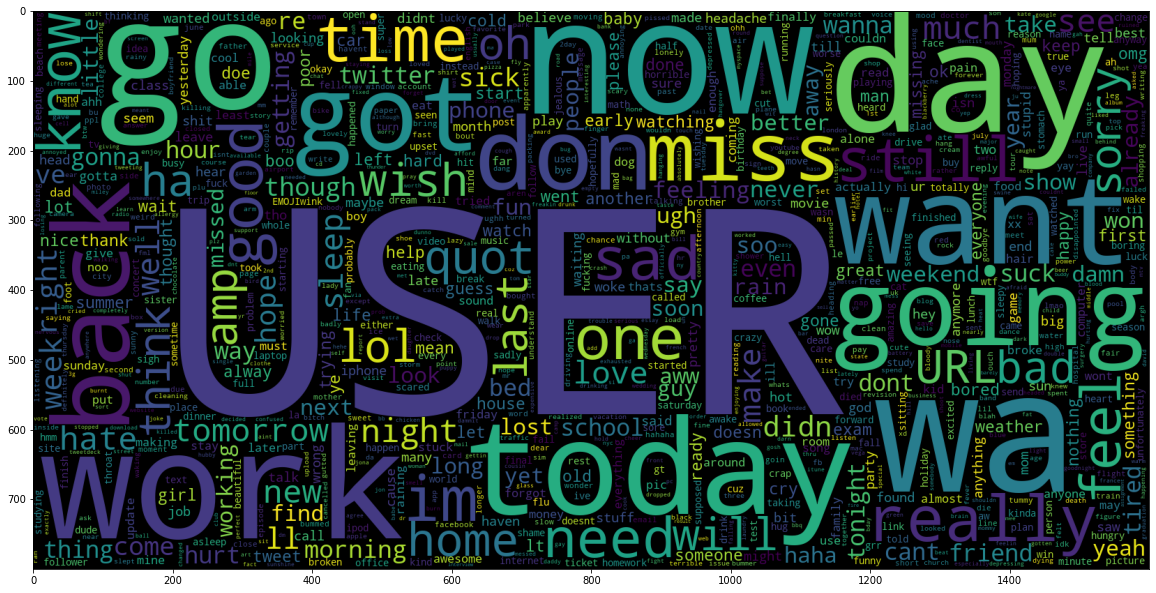

In [44]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word-Cloud for Positive tweets.


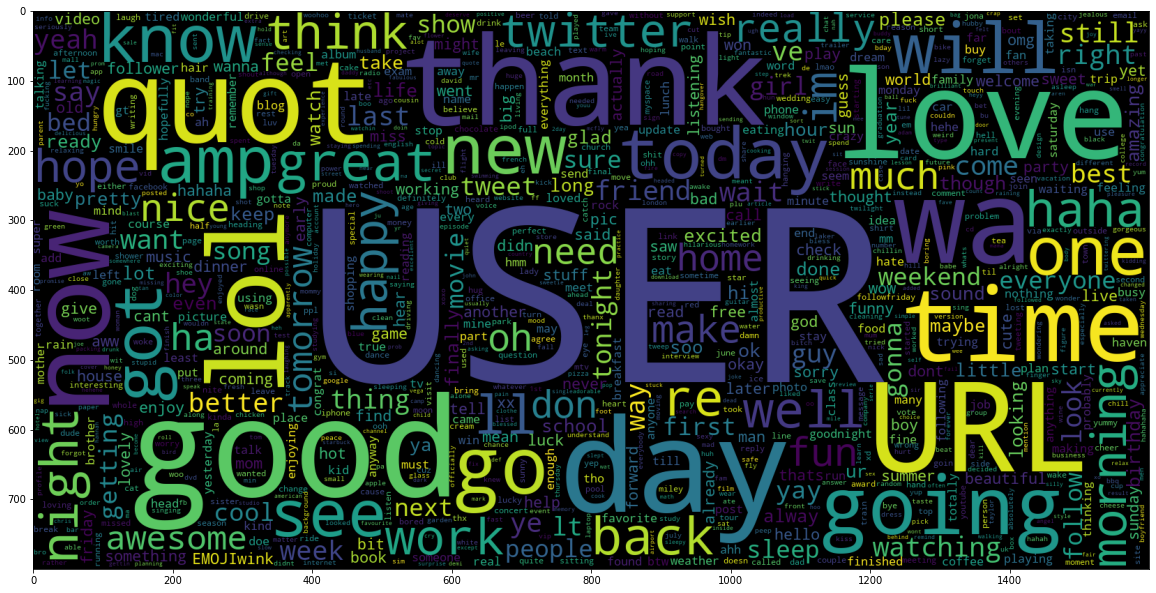

In [45]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [46]:
SEQUENCE_LENGTH = 280

In [47]:
import tensorflow as tf

In [48]:
import tensorflow as tf

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processedtext)
sequences = tokenizer.texts_to_sequences(processedtext)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 249776


In [51]:
vocabulary =  tokenizer.word_index
print('Found %s unique tokens.' % len(vocabulary))


Found 249775 unique tokens.


In [52]:
x_train_ = pad_sequences(tokenizer.texts_to_sequences(processedtext), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(processed_test_text), maxlen=SEQUENCE_LENGTH)
Y_test = test_sentiment

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(x_train_, sentiment,test_size = 0.05, random_state = 42  )
print(f'Data Split done.')

Data Split done.


In [54]:
len(Y_validation)

80000

In [55]:
len(Y_train)

1519999

In [56]:
len(Y_test)

358

In [57]:
x_test.shape

(358, 280)

In [58]:
x_train_.shape

(1599999, 280)

In [59]:
X_validation.shape

(80000, 280)

In [60]:
EMBEDDING_DIM = 300

In [61]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM))


In [62]:
# embeddingsDictionary = embeddings.to_dict()

In [63]:
for word, idx in vocabulary.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embedding_vector

In [71]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy
embedding_layer = Embedding(vocab_size,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


In [72]:
model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [73]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]

model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [74]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [75]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [80]:
BATCH_SIZE = 512
EPOCHS = 20

In [81]:
history = model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/20
1930/2969 [==================>...........] - ETA: 33:16 - loss: 0.4797 - accuracy: 0.7681 - precision: 0.7700 - recall: 0.7645

KeyboardInterrupt: ignored

In [82]:
score = model.evaluate(X_test, Y_test)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

NameError: ignored

In [83]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: ignored

In [84]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

In [85]:
def decode_sentiment(score):
  SENTIMENT_THRESHOLDS = 0.5
  if score <= SENTIMENT_THRESHOLD:
      label = NEGATIVE
  elif score >= SENTIMENT_THRESHOLDS:
      label = POSITIVE

  return label


In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score )

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
# TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
# SENTIMENT_THRESHOLD = 0.5


In [ ]:
# KERAS_MODEL = "model.h5"
# WORD2VEC_MODEL = "model.w2v"
# TOKENIZER_MODEL = "tokenizer.pkl"
# ENCODER_MODEL = "encoder.pkl"